In [1]:
import sys
sys.path.append('..')

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from marked_card_detector.card import *

In [3]:
def displays(imgs, grayscale=False):
    for img in imgs:
        if grayscale:
            plt.imshow(img, cmap='gray', vmin = 0, vmax = 255)
        else:
            plt.imshow(img)
        plt.show()

In [4]:
img = cv2.imread("../tests/images/1-right.jpg")

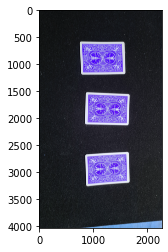

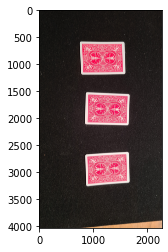

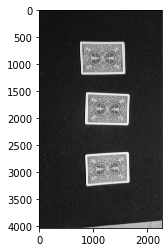

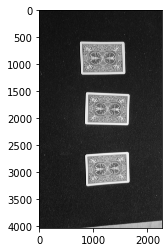

In [5]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# cv2.imwrite("tmp.png", cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_blur = cv2.GaussianBlur(img_gray, (3,3), 0)
# blur = cv2.GaussianBlur(gray,(5,5),0)
displays([img, img_rgb, img_gray, img_blur], True)

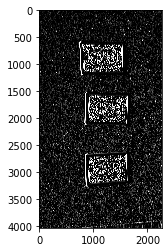

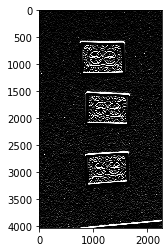

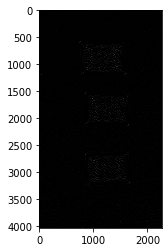

In [6]:
# Sobel Edge Detection
sobelx = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=5) # Sobel Edge Detection on the X axis
sobely = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=5) # Sobel Edge Detection on the Y axis
sobelxy = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=5) # Combined X and Y Sobel Edge Detection

# Display Sobel Edge Detection Images
displays([sobelx, sobely, sobelxy], True)


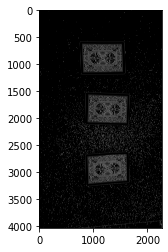

In [7]:
edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200)
displays([edges], True)

In [8]:
### Constants ###

# https://github.com/EdjeElectronics/OpenCV-Playing-Card-Detector/blob/master/Cards.py

# Adaptive threshold levels
BKG_THRESH = 60

CARD_MAX_AREA = 120000
CARD_MIN_AREA = 25000

CARD_MAX_AREA = 120_000_000
CARD_MIN_AREA = 1_000



In [9]:
def preprocess_image(image):
    """Returns a grayed, blurred, and adaptively thresholded camera image."""

    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(5,5),0)

    # The best threshold level depends on the ambient lighting conditions.
    # For bright lighting, a high threshold must be used to isolate the cards
    # from the background. For dim lighting, a low threshold must be used.
    # To make the card detector independent of lighting conditions, the
    # following adaptive threshold method is used.
    #
    # A background pixel in the center top of the image is sampled to determine
    # its intensity. The adaptive threshold is set at 50 (THRESH_ADDER) higher
    # than that. This allows the threshold to adapt to the lighting conditions.
    img_w, img_h = np.shape(image)[:2]
    bkg_level = gray[int(img_h/100)][int(img_w/2)]
    thresh_level = bkg_level + BKG_THRESH

    retval, thresh = cv2.threshold(blur,thresh_level,255,cv2.THRESH_BINARY)
    
    return thresh

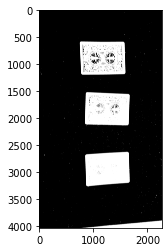

In [10]:
thresh = preprocess_image(img)
displays([thresh], True)

In [11]:
def find_cards(thresh_image):
    """Finds all card-sized contours in a thresholded camera image.
    Returns the number of cards, and a list of card contours sorted
    from largest to smallest."""

    # Find contours and sort their indices by contour size
    cnts, hier = cv2.findContours(thresh_image,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    index_sort = sorted(range(len(cnts)), key=lambda i : cv2.contourArea(cnts[i]),reverse=True)

    # If there are no contours, do nothing
    if len(cnts) == 0:
        return [], []
    
    # Otherwise, initialize empty sorted contour and hierarchy lists
    cnts_sort = []
    hier_sort = []
    cnt_is_card = np.zeros(len(cnts),dtype=int)

    # Fill empty lists with sorted contour and sorted hierarchy. Now,
    # the indices of the contour list still correspond with those of
    # the hierarchy list. The hierarchy array can be used to check if
    # the contours have parents or not.
    for i in index_sort:
        cnts_sort.append(cnts[i])
        hier_sort.append(hier[0][i])

    # Determine which of the contours are cards by applying the
    # following criteria: 1) Smaller area than the maximum card size,
    # 2), bigger area than the minimum card size, 3) have no parents,
    # and 4) have four corners

    for i in range(len(cnts_sort)):
        size = cv2.contourArea(cnts_sort[i])
        peri = cv2.arcLength(cnts_sort[i],True)
        approx = cv2.approxPolyDP(cnts_sort[i],0.01*peri,True)
        
        if ((size < CARD_MAX_AREA) and (size > CARD_MIN_AREA)
            and (hier_sort[i][3] == -1) and (len(approx) == 4)):
            cnt_is_card[i] = 1

    return cnts_sort, cnt_is_card

In [12]:
cnts_sort, cnt_is_card = find_cards(thresh)

In [13]:
# Initialize a new "cards" list to assign the card objects.
# k indexes the newly made array of cards.
cards = []
k = 0

# For each contour detected:
for i in range(len(cnts_sort)):
    if (cnt_is_card[i] == 1):

        cards.append(Card(cnts_sort[i], img))

        # Find the best rank and suit match for the card.
#         cards[k].best_rank_match,cards[k].best_suit_match,cards[k].rank_diff,cards[k].suit_diff = Cards.match_card(cards[k],train_ranks,train_suits)

        # Draw center point and match result on the image.
#         image = Cards.draw_results(image, cards[k])
        k = k + 1

In [14]:
cards[0].center, cards[1].center, cards[2].center

([1175, 888], [1257, 1830], [1260, 2935])

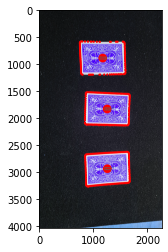

In [15]:
for card in cards:
    card.draw()
displays([img])

24480


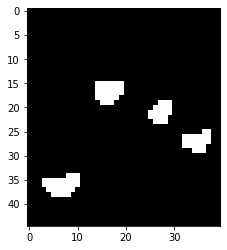

17850


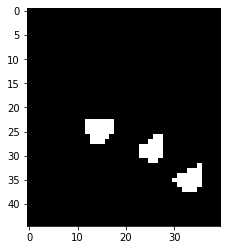

1530


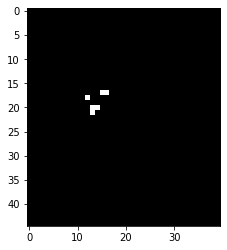

In [47]:
def deep(img, got_here, x,  y):
    
    if x < 0 or y < 0 or x >= img.shape[1] or y >= img.shape[0] or got_here[y, x]==1:
        return
    
    if img[y][x] != 255:
        return

    got_here[y, x] = 1
    img[y, x] = 0
    
#     print(y, x)
    deep(img, got_here, x - 1, y)
    deep(img, got_here, x + 1, y)
    deep(img, got_here, x, y - 1)
    deep(img, got_here, x, y + 1)

    
def floating_white(img):
    got_here = np.zeros(img.shape)

    for x in range(img.shape[1]):
        deep(img, got_here, x, 0)
        deep(img, got_here, x, img.shape[0] - 1)

    for y in range(img.shape[0]):
        deep(img, got_here, 0, y)
        deep(img, got_here, img.shape[1] - 1, y)
    return np.sum(img)
    

for card in cards:
    top_left = card.warp[140:185, 140:180]
    (thresh, bw) = cv2.threshold(top_left, 127, 255, cv2.THRESH_BINARY)
    print(floating_white(bw))
    displays([bw], True)